# IDENTIFICAÇÃO DE FOGO EM IMAGENS UTILIZANDO TÉCNICAS DE CLASSIFICAÇÃO

Um problema de visão computacional que utiliza uma abordagem de aprendizado supervisionada para classificar imagens de acordo com a presença e ausência de fogo.

- **Descrição da base de dados:** A base de dados possui imagens com e sem fogo ao ar livre para tarefas de visão computacional. Ao todo são 999 imagens, onde 755 são de fogo ao ar livre podendo apresentar fumaça densa, e 244 não são de fogo e podem apresentar grama, estradas, árvores, florestas, lagos, rios, cachoeiras, animais e pessoas. 


- **Link da base de dados original:** https://www.kaggle.com/datasets/phylake1337/fire-dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [ ]:
!pip install mlflow --quiet

     |████████████████████████████████| 17.0 MB 7.9 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 146 kB 73.0 MB/s 
     |████████████████████████████████| 181 kB 71.6 MB/s 
     |████████████████████████████████| 209 kB 56.8 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 


In [ ]:
# !mlflow ui --port 5000
get_ipython().system_raw("mlflow ui --port 5000 &")

In [ ]:
#@title constants.py

# import os
# base_dir = os.path.realpath(__file__).split('/src')[0]

# PREFIX_PATH = "/content/"
# TMP_DIR_PATH = "/tmp/models/"
# MODELS_OUTPUT_PATH = "{}/models/".format(base_dir)
# PREFIX_PROCESSED_DATA_PATH = "{}/data/processed/".format(base_dir)
# PREFIX_PATH_PERSONAL_IMAGES = "{}/data/raw/personal_images/".format(base_dir)



PREFIX_PATH = "/content/"
base_dir = "/gdrive/MyDrive/Colab Notebooks/fire_image_classification"
TMP_DIR_PATH = "/tmp/models/"
MODELS_OUTPUT_PATH = "{}/models/".format(base_dir)
PREFIX_PROCESSED_DATA_PATH = "{}/data/processed/".format(base_dir)
PREFIX_PATH_PERSONAL_IMAGES = "{}/data/raw/personal_images/".format(base_dir)

IMG_HEIGHT = 100
IMG_WIDTH = 100
RESIZE_Y = 100
RESIZE_X = 100
RESIZE_Y = 100
CHANNEL = 3
FLATTEN_SHAPE = RESIZE_X * RESIZE_Y * CHANNEL
COLUMNS_PIXELS = ["pixel{}".format(i) for i in range(0, FLATTEN_SHAPE)]

COLOR_HIST_RANGE = range(0, 256)
COLUMNS_HIST_B = ["hist_b_{}".format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_G = ["hist_g_{}".format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_R = ["hist_r_{}".format(i) for i in COLOR_HIST_RANGE]
HIST_COLUMNS = COLUMNS_HIST_B + COLUMNS_HIST_G + COLUMNS_HIST_R

TOTAL_PIXELS_COLUMNS = FLATTEN_SHAPE + (256 * 3)

pixels_hist_columns = COLUMNS_PIXELS + COLUMNS_HIST_B + COLUMNS_HIST_G + COLUMNS_HIST_R
desc_columns = [
    "image_path",
    "label",
    "label_name",
    "source_shape",
    "source_height",
    "source_width",
    "source_channel",
]
COLUMNS_FULL_DF = desc_columns + pixels_hist_columns

NOISES = ["gaussian", "localvar", "poisson", "salt", "pepper", "s&p", "speckle"]

LABEL_DATA = {0: (0, "Sem fogo"), 1: (1, "Com fogo")}


In [ ]:
#@title input_output_processing.py

import joblib
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# from src.constants import (CHANNEL, COLUMNS_PIXELS, IMG_HEIGHT, IMG_WIDTH,
#                            MODELS_OUTPUT_PATH, PREFIX_PROCESSED_DATA_PATH)


def get_df_train_test(prefix_path=PREFIX_PROCESSED_DATA_PATH, df=None, split=True):
    if split:
        df_train, df_test = train_test_split(df, test_size=0.20, stratify=df["label"])
        df_train.to_csv("{}train_images.csv".format(prefix_path), index=False)
        df_test.to_csv("{}test_images.csv".format(prefix_path), index=False)
    else:
        df_train = pd.read_csv("{}train_images.csv".format(prefix_path))
        df_test = pd.read_csv("{}test_images.csv".format(prefix_path))
    return df_train, df_test


def get_df_train_valid(prefix_path=PREFIX_PROCESSED_DATA_PATH, df=None, split=True):
    df_train = df.copy()
    if split:
        df_train, df_valid = train_test_split(df_train, test_size=0.10, stratify=df["label"])
        df_valid.to_csv("{}valid_images.csv".format(prefix_path), index=False)
    else:
        df_valid = pd.read_csv("{}valid_images.csv".format(prefix_path))

    df_train = df_train.loc[~df_train["image_path"].isin(df_valid["image_path"])]
    return df_train, df_valid


def drop_valid_albumented_images_from_train_data(df_train_aux, df_valid):
    df_valid_aux = df_train_aux.loc[
        df_train_aux["image_path"].isin(df_valid["image_path"])
    ]
    df_train_aux = df_train_aux.loc[
        ~df_train_aux["image_path"].isin(df_valid["image_path"])
    ]

    return df_train_aux, df_valid_aux


def get_df_train_with_albumentations_and_noises(df_train):
    main_columns = ["image_path", "label", "label_name"]
    columns = main_columns + COLUMNS_PIXELS

    df_train_1 = df_train.loc[df_train["label"] == 1][columns].copy()
    df_train_1["pre_process_type"] = "Original"

    df_train_0 = df_train.loc[df_train["label"] == 0][columns].copy()
    df_train_0["pre_process_type"] = "Original"

    df_albumentations = pd.read_csv(
        "{}train_images_albumentation.csv".format(PREFIX_PROCESSED_DATA_PATH)
    )
    df_noises = pd.read_csv(
        "{}train_images_noise.csv".format(PREFIX_PROCESSED_DATA_PATH)
    )

    df_train_aux = (
        pd.concat(
            [df_train_0, df_albumentations, df_noises, df_train_1], ignore_index=True
        )
        .sort_values(
            ["label", "image_path", "pre_process_type"], ascending=[True, True, False]
        )
        .reset_index(drop=True)
    )
    return df_train_aux


def get_processed_input_model(
    df, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, channels=CHANNEL
):
    X = df[COLUMNS_PIXELS]
    y = df["label"]

    X_scaled = X / 255.0

    X_scaled_cnn = (
        X_scaled.to_numpy()
        .reshape(X_scaled.shape[0], img_height, img_width, CHANNEL)
        .copy()
    )

    return X, y, X_scaled, X_scaled_cnn


def save_model(model, prefix_filename, model_type="sklearn"):
    if model_type == "sklearn":
        joblib.dump(model, "{}.sav".format(prefix_filename))
    elif model_type == "tf":
        model.save("{}.h5".format(prefix_filename))


def load_model(prefix_filename, model_type="sklearn"):
    if model_type == "sklearn":
        model = joblib.load("{}.sav".format(prefix_filename))
    elif model_type == "tf":
        model = tf.keras.models.load_model("{}.h5".format(prefix_filename))
    return model


def describe_results(y_true, y_pred, target_names=None, labels=None):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: ", accuracy)

    print(
        classification_report(y_true, y_pred, target_names=target_names, labels=labels)
    )

In [ ]:
#@title visualize.py

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.metrics import (PrecisionRecallDisplay, RocCurveDisplay,
                             confusion_matrix)



def plot_confusion_matrix(y_true, y_pred, prefix_filename, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    # cm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.axes()

    sns.heatmap(cm, annot=True, annot_kws={"size": 30}, fmt="d", cmap="Blues", ax=ax)
    ax.set_title("Confusion Matrix")
    plt.show()
    # plt.savefig('{}.png'.format(prefix_filename))

def compare_evaluation_metrics(df, dataset=None, image_path=None):
    df_0 = df.loc[df["label"] == 0]
    df_1 = df.loc[df["label"] == 1]

    total_models = len(df["model_name"].unique())
    fig = make_subplots(
        rows=2, cols=2, subplot_titles=("Accuracy", "Precision", "Recall", "F1 Score")
    )
    acc_colors = [
        "gray",
    ] * total_models
    b_colors = [
        "blue",
    ] * total_models
    r_colors = [
        "red",
    ] * total_models

    fig.add_trace(
        go.Bar(
            x=df_0["model_name"],
            y=round(df_0["accuracy"] * 100, 2),
            text=round(df_0["accuracy"] * 100, 2),
            textposition="auto",
            marker_color=acc_colors,
            showlegend=False,
        ),
        row=1,
        col=1,
    )

    for metric, row, col in [("precision", 1, 2), ("recall", 2, 1), ("f1_score", 2, 2)]:
        showlegend = False if metric != "precision" else True
        fig.add_trace(
            go.Bar(
                x=df_0["model_name"],
                y=round(df_0[metric] * 100, 2),
                text=round(df_0[metric] * 100, 2),
                textposition="auto",
                marker_color=b_colors,
                name="Sem fogo",
                showlegend=showlegend,
            ),
            row=row,
            col=col,
        )
        fig.add_trace(
            go.Bar(
                x=df_1["model_name"],
                y=round(df_1[metric] * 100, 2),
                text=round(df_1[metric] * 100, 2),
                textposition="auto",
                marker_color=r_colors,
                name="Com fogo",
                showlegend=showlegend,
            ),
            row=row,
            col=col,
        )

    fig.update_layout(title_text="[{}] - Métricas de avaliação dos modelos".format(dataset))
    fig.show()
    # fig.write_image("{}.png".format(image_path))
    # fig.write_html("{}.html".format(image_path))



def plot_train_history(df_history, image_path):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "F1 Score"))

    fig.add_trace(
        go.Scatter(
            x=df_history.index,
            y=df_history["loss"],
            mode="lines",
            name="Loss",
            marker_color="gray",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=df_history.index,
            y=df_history["val_loss"],
            mode="lines",
            name="Val loss",
            marker_color="blue",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=df_history.index,
            y=df_history["f1_score"],
            mode="lines",
            name="F1 score",
            marker_color="gray",
        ),
        row=1,
        col=2,
    )
    fig.add_trace(
        go.Scatter(
            x=df_history.index,
            y=df_history["val_f1_score"],
            mode="lines",
            name="Val F1 score",
            marker_color="blue",
        ),
        row=1,
        col=2,
    )
    fig.show()
    # fig.write_image("{}.png".format(image_path))
    # fig.write_html("{}.html".format(image_path))


# Logistic Regression

Active run_id: 4e68bf17be194f6c97c602418326cba4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Classes: [0 1]
Coef shape: (1, 30000)
Coef:  [[ 0.01519728 -0.00080411 -0.024375   ... -0.01994567 -0.01656602
  -0.01882608]]
Accuracy:  0.925
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        19
           1       0.98      0.92      0.95        61

    accuracy                           0.93        80
   macro avg       0.88      0.93      0.90        80
weighted avg       0.93      0.93      0.93        80



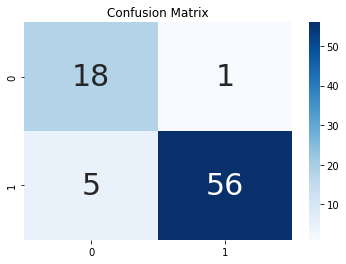

Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       519
           1       1.00      1.00      1.00       540

    accuracy                           1.00      1059
   macro avg       1.00      1.00      1.00      1059
weighted avg       1.00      1.00      1.00      1059



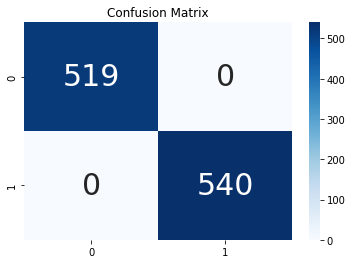

In [ ]:
#@title Logistic Regression com albumentation

import logging
import os
import shutil

import joblib
import mlflow
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from src.constants import PREFIX_PROCESSED_DATA_PATH, TMP_DIR_PATH
# from src.input_output_processing import (
#     describe_results, drop_valid_albumented_images_from_train_data,
#     get_df_train_test, get_df_train_valid,
#     get_df_train_with_albumentations_and_noises, get_processed_input_model)
# from src.visualization.visualize import plot_confusion_matrix

TAG = "LR"


def train(
    X_train_scaled,
    y_train,
    run_id,
):
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    print("Classes:", model.classes_[::])
    print("Coef shape:", model.coef_.shape)
    print("Coef: ", model.coef_)

    if os.path.exists(TMP_DIR_PATH):
        shutil.rmtree(TMP_DIR_PATH)
    os.makedirs(TMP_DIR_PATH)

    prefix_filename = "{dir_path}/{tag}_{run_id}.sav".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id
    )
    joblib.dump(model, prefix_filename)
    return model


def predict(model, type_data, X_test_scaled, y_test, run_id):
    # Predicting the Test set results
    y_pred = model.predict(X_test_scaled)

    # Predict probabilities
    probs_y = model.predict_proba(X_test_scaled)

    y_score = model.decision_function(X_test_scaled)

    y_true = y_test
    df_y_true_pred = pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
            "non_prob": probs_y[:, 0],
            "fire_prob": probs_y[:, 1],
            "y_score": y_score,
        }
    )

    y_true = df_y_true_pred["y_true"]
    y_pred = df_y_true_pred["y_pred"]

    accuracy = accuracy_score(y_true, y_pred)
    precision_recall_fscore_support_metrics = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    df_precision_recall_fscore_support = pd.DataFrame(
        precision_recall_fscore_support_metrics,
        columns=[0, 1],
        index=["precision", "recall", "f1_score", "support"],
    ).T
    df_precision_recall_fscore_support["accuracy"] = accuracy
    df_precision_recall_fscore_support["model_name"] = "{}_{}".format(TAG, run_id)
    df_precision_recall_fscore_support = (
        df_precision_recall_fscore_support.reset_index().rename(
            columns={"index": "label"}
        )
    )

    prefix_filename = "{dir_path}/{tag}_{run_id}_{type_data}".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id, type_data=type_data
    )
    df_precision_recall_fscore_support.to_csv(
        "{}_metrics.csv".format(prefix_filename), index=False
    )

    describe_results(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, prefix_filename=prefix_filename)


def main():
    logging.info("Starting run {}".format(TAG))

    df_train, df_test = get_df_train_test(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, split=False
    )
    df_train, df_valid = get_df_train_valid(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, df=df_train, split=False
    )

    df_train_aux = get_df_train_with_albumentations_and_noises(df_train)
    df_train_aux, _ = drop_valid_albumented_images_from_train_data(
        df_train_aux, df_valid
    )

    (
        X_train_aux,
        y_train_aux,
        X_train_scaled_aux,
        X_train_scaled_cnn_aux,
    ) = get_processed_input_model(df_train_aux)
    X_valid, y_valid, X_valid_scaled, X_valid_scaled_cnn = get_processed_input_model(
        df_valid
    )
    X_test, y_test, X_test_scaled, X_test_scaled_cnn = get_processed_input_model(
        df_train_aux
    )

    with mlflow.start_run() as run:
        mlflow.set_tag("model.version", TAG)
        run = mlflow.active_run()
        run_id = run.info.run_id

        logging.info("Active run_id: {}".format(run_id))
        print("Active run_id: {}".format(run_id))

        mlflow.sklearn.autolog()

        model = train(
            X_train_scaled_aux,
            y_train_aux,
            run_id,
        )
        predict(model, "valid", X_valid_scaled, y_valid, run_id)
        predict(model, "test", X_test_scaled, y_test, run_id)

        mlflow.log_artifacts(TMP_DIR_PATH)
    mlflow.end_run()

    logging.info("Ending run {}".format(TAG))


# if __name__ == "__main__":
main()

# SVM

Active run_id: 2b8e7ef28381438d84df5226f588d763
Classes: [0 1]
Accuracy:  0.8125
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        19
           1       0.91      0.84      0.87        61

    accuracy                           0.81        80
   macro avg       0.75      0.79      0.76        80
weighted avg       0.83      0.81      0.82        80



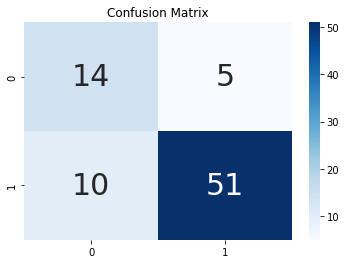

Accuracy:  0.9782813975448537
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       519
           1       1.00      0.96      0.98       540

    accuracy                           0.98      1059
   macro avg       0.98      0.98      0.98      1059
weighted avg       0.98      0.98      0.98      1059



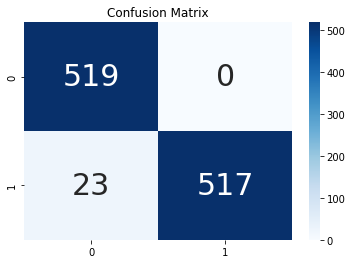

In [ ]:
#@title SVM com albumentation

import logging
import os
import shutil

import joblib
import mlflow
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from src.constants import PREFIX_PROCESSED_DATA_PATH, TMP_DIR_PATH
# from src.input_output_processing import (
#     describe_results, drop_valid_albumented_images_from_train_data,
#     get_df_train_test, get_df_train_valid,
#     get_df_train_with_albumentations_and_noises, get_processed_input_model)
# from src.visualization.visualize import plot_confusion_matrix

TAG = "SVM"


def train(
    X_train_scaled,
    y_train,
    run_id,
):
    model = SVC(kernel='poly', probability=True)
    model.fit(X_train_scaled, y_train)

    print("Classes:", model.classes_[::])
    # print("Coef shape:", model.coef_.shape)
    # print("Coef: ", model.coef_)

    if os.path.exists(TMP_DIR_PATH):
        shutil.rmtree(TMP_DIR_PATH)
    os.makedirs(TMP_DIR_PATH)

    prefix_filename = "{dir_path}/{tag}_{run_id}.sav".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id
    )
    joblib.dump(model, prefix_filename)
    return model


def predict(model, type_data, X_test_scaled, y_test, run_id):
    # Predicting the Test set results
    y_pred = model.predict(X_test_scaled)

    # Predict probabilities
    probs_y = model.predict_proba(X_test_scaled)

    y_score = model.decision_function(X_test_scaled)

    y_true = y_test
    df_y_true_pred = pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
            "non_prob": probs_y[:, 0],
            "fire_prob": probs_y[:, 1],
            "y_score": y_score,
        }
    )

    y_true = df_y_true_pred["y_true"]
    y_pred = df_y_true_pred["y_pred"]

    accuracy = accuracy_score(y_true, y_pred)
    precision_recall_fscore_support_metrics = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    df_precision_recall_fscore_support = pd.DataFrame(
        precision_recall_fscore_support_metrics,
        columns=[0, 1],
        index=["precision", "recall", "f1_score", "support"],
    ).T
    df_precision_recall_fscore_support["accuracy"] = accuracy
    df_precision_recall_fscore_support["model_name"] = "{}_{}".format(TAG, run_id)
    df_precision_recall_fscore_support = (
        df_precision_recall_fscore_support.reset_index().rename(
            columns={"index": "label"}
        )
    )

    prefix_filename = "{dir_path}/{tag}_{run_id}_{type_data}".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id, type_data=type_data
    )
    df_precision_recall_fscore_support.to_csv(
        "{}_metrics.csv".format(prefix_filename), index=False
    )

    describe_results(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, prefix_filename=prefix_filename)


def main():
    logging.info("Starting run {}".format(TAG))

    df_train, df_test = get_df_train_test(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, split=False
    )
    df_train, df_valid = get_df_train_valid(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, df=df_train, split=False
    )

    df_train_aux = get_df_train_with_albumentations_and_noises(df_train)
    df_train_aux, _ = drop_valid_albumented_images_from_train_data(
        df_train_aux, df_valid
    )

    (
        X_train_aux,
        y_train_aux,
        X_train_scaled_aux,
        X_train_scaled_cnn_aux,
    ) = get_processed_input_model(df_train_aux)
    X_valid, y_valid, X_valid_scaled, X_valid_scaled_cnn = get_processed_input_model(
        df_valid
    )
    X_test, y_test, X_test_scaled, X_test_scaled_cnn = get_processed_input_model(
        df_train_aux
    )

    with mlflow.start_run() as run:
        mlflow.set_tag("model.version", TAG)
        run = mlflow.active_run()
        run_id = run.info.run_id

        logging.info("Active run_id: {}".format(run_id))
        print("Active run_id: {}".format(run_id))

        mlflow.sklearn.autolog()

        model = train(
            X_train_scaled_aux,
            y_train_aux,
            run_id,
        )
        predict(model, "valid", X_valid_scaled, y_valid, run_id)
        predict(model, "test", X_test_scaled, y_test, run_id)

        mlflow.log_artifacts(TMP_DIR_PATH)
    mlflow.end_run()

    logging.info("Ending run {}".format(TAG))


# if __name__ == "__main__":
main()

# CNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 512)       38912     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 512)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 256)       3277056   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 256)      

/usr/local/lib/python3.7/dist-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning:

Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.



Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 1.3000 - binary_crossentropy: 1.3000 - accuracy: 0.0113 - precision_1: 0.5764 - recall_1: 0.6704 - f1_score: 0.6199

2022/09/01 10:45:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 24s 2s/step - loss: 1.3000 - binary_crossentropy: 1.3000 - accuracy: 0.0113 - precision_1: 0.5764 - recall_1: 0.6704 - f1_score: 0.6199 - val_loss: 0.9047 - val_binary_crossentropy: 0.9047 - val_accuracy: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.7027 - binary_crossentropy: 0.7027 - accuracy: 0.0000e+00 - precision_1: 0.5346 - recall_1: 0.6296 - f1_score: 0.5782

2022/09/01 10:45:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 549ms/step - loss: 0.7027 - binary_crossentropy: 0.7027 - accuracy: 0.0000e+00 - precision_1: 0.5346 - recall_1: 0.6296 - f1_score: 0.5782 - val_loss: 0.6307 - val_binary_crossentropy: 0.6307 - val_accuracy: 0.0000e+00 - val_precision_1: 0.7625 - val_recall_1: 1.0000 - val_f1_score: 0.8652
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.6945 - binary_crossentropy: 0.6945 - accuracy: 0.0000e+00 - precision_1: 0.5230 - recall_1: 0.7148 - f1_score: 0.6041

2022/09/01 10:45:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 535ms/step - loss: 0.6945 - binary_crossentropy: 0.6945 - accuracy: 0.0000e+00 - precision_1: 0.5230 - recall_1: 0.7148 - f1_score: 0.6041 - val_loss: 0.6359 - val_binary_crossentropy: 0.6359 - val_accuracy: 0.0000e+00 - val_precision_1: 0.7625 - val_recall_1: 1.0000 - val_f1_score: 0.8652
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6781 - binary_crossentropy: 0.6781 - accuracy: 0.0000e+00 - precision_1: 0.5686 - recall_1: 0.8593 - f1_score: 0.6844

2022/09/01 10:46:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 537ms/step - loss: 0.6781 - binary_crossentropy: 0.6781 - accuracy: 0.0000e+00 - precision_1: 0.5686 - recall_1: 0.8593 - f1_score: 0.6844 - val_loss: 0.6438 - val_binary_crossentropy: 0.6438 - val_accuracy: 0.0000e+00 - val_precision_1: 0.7619 - val_recall_1: 0.7869 - val_f1_score: 0.7742
Epoch 5/20
8/8 [==============================] - ETA: 0s - loss: 0.6297 - binary_crossentropy: 0.6297 - accuracy: 0.0000e+00 - precision_1: 0.6667 - recall_1: 0.8519 - f1_score: 0.7480

2022/09/01 10:46:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 528ms/step - loss: 0.6297 - binary_crossentropy: 0.6297 - accuracy: 0.0000e+00 - precision_1: 0.6667 - recall_1: 0.8519 - f1_score: 0.7480 - val_loss: 0.5531 - val_binary_crossentropy: 0.5531 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9184 - val_recall_1: 0.7377 - val_f1_score: 0.8182
Epoch 6/20
8/8 [==============================] - ETA: 0s - loss: 0.4719 - binary_crossentropy: 0.4719 - accuracy: 0.0000e+00 - precision_1: 0.8472 - recall_1: 0.8315 - f1_score: 0.8393

2022/09/01 10:46:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 541ms/step - loss: 0.4719 - binary_crossentropy: 0.4719 - accuracy: 0.0000e+00 - precision_1: 0.8472 - recall_1: 0.8315 - f1_score: 0.8393 - val_loss: 0.3350 - val_binary_crossentropy: 0.3350 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9273 - val_recall_1: 0.8361 - val_f1_score: 0.8793
Epoch 7/20
8/8 [==============================] - ETA: 0s - loss: 0.3743 - binary_crossentropy: 0.3743 - accuracy: 0.0000e+00 - precision_1: 0.9061 - recall_1: 0.8759 - f1_score: 0.8908

2022/09/01 10:46:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 538ms/step - loss: 0.3743 - binary_crossentropy: 0.3743 - accuracy: 0.0000e+00 - precision_1: 0.9061 - recall_1: 0.8759 - f1_score: 0.8908 - val_loss: 0.2233 - val_binary_crossentropy: 0.2233 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9516 - val_recall_1: 0.9672 - val_f1_score: 0.9593
Epoch 8/20
8/8 [==============================] - ETA: 0s - loss: 0.3722 - binary_crossentropy: 0.3722 - accuracy: 0.0000e+00 - precision_1: 0.8980 - recall_1: 0.8481 - f1_score: 0.8724

2022/09/01 10:46:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 516ms/step - loss: 0.3722 - binary_crossentropy: 0.3722 - accuracy: 0.0000e+00 - precision_1: 0.8980 - recall_1: 0.8481 - f1_score: 0.8724 - val_loss: 0.2444 - val_binary_crossentropy: 0.2444 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9365 - val_recall_1: 0.9672 - val_f1_score: 0.9516
Epoch 9/20
8/8 [==============================] - ETA: 0s - loss: 0.2537 - binary_crossentropy: 0.2537 - accuracy: 0.0000e+00 - precision_1: 0.9264 - recall_1: 0.9093 - f1_score: 0.9178

2022/09/01 10:46:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 514ms/step - loss: 0.2537 - binary_crossentropy: 0.2537 - accuracy: 0.0000e+00 - precision_1: 0.9264 - recall_1: 0.9093 - f1_score: 0.9178 - val_loss: 0.1938 - val_binary_crossentropy: 0.1938 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9667 - val_recall_1: 0.9508 - val_f1_score: 0.9587
Epoch 10/20
8/8 [==============================] - ETA: 0s - loss: 0.1675 - binary_crossentropy: 0.1675 - accuracy: 0.0000e+00 - precision_1: 0.9405 - recall_1: 0.9370 - f1_score: 0.9388

2022/09/01 10:46:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 514ms/step - loss: 0.1675 - binary_crossentropy: 0.1675 - accuracy: 0.0000e+00 - precision_1: 0.9405 - recall_1: 0.9370 - f1_score: 0.9388 - val_loss: 0.1985 - val_binary_crossentropy: 0.1985 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9828 - val_recall_1: 0.9344 - val_f1_score: 0.9580
Epoch 11/20
8/8 [==============================] - ETA: 0s - loss: 0.1254 - binary_crossentropy: 0.1254 - accuracy: 0.0000e+00 - precision_1: 0.9551 - recall_1: 0.9463 - f1_score: 0.9507

2022/09/01 10:46:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 511ms/step - loss: 0.1254 - binary_crossentropy: 0.1254 - accuracy: 0.0000e+00 - precision_1: 0.9551 - recall_1: 0.9463 - f1_score: 0.9507 - val_loss: 0.2242 - val_binary_crossentropy: 0.2242 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9828 - val_recall_1: 0.9344 - val_f1_score: 0.9580
Epoch 12/20
8/8 [==============================] - ETA: 0s - loss: 0.1092 - binary_crossentropy: 0.1092 - accuracy: 0.0000e+00 - precision_1: 0.9522 - recall_1: 0.9593 - f1_score: 0.9557

2022/09/01 10:46:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 511ms/step - loss: 0.1092 - binary_crossentropy: 0.1092 - accuracy: 0.0000e+00 - precision_1: 0.9522 - recall_1: 0.9593 - f1_score: 0.9557 - val_loss: 0.2362 - val_binary_crossentropy: 0.2362 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9828 - val_recall_1: 0.9344 - val_f1_score: 0.9580
Epoch 13/20
8/8 [==============================] - ETA: 0s - loss: 0.1032 - binary_crossentropy: 0.1032 - accuracy: 0.0000e+00 - precision_1: 0.9573 - recall_1: 0.9556 - f1_score: 0.9564

2022/09/01 10:46:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 528ms/step - loss: 0.1032 - binary_crossentropy: 0.1032 - accuracy: 0.0000e+00 - precision_1: 0.9573 - recall_1: 0.9556 - f1_score: 0.9564 - val_loss: 0.1762 - val_binary_crossentropy: 0.1762 - val_accuracy: 0.0375 - val_precision_1: 0.9831 - val_recall_1: 0.9508 - val_f1_score: 0.9667
Epoch 14/20
8/8 [==============================] - ETA: 0s - loss: 0.0977 - binary_crossentropy: 0.0977 - accuracy: 0.0293 - precision_1: 0.9565 - recall_1: 0.9778 - f1_score: 0.9670

2022/09/01 10:46:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 509ms/step - loss: 0.0977 - binary_crossentropy: 0.0977 - accuracy: 0.0293 - precision_1: 0.9565 - recall_1: 0.9778 - f1_score: 0.9670 - val_loss: 0.2613 - val_binary_crossentropy: 0.2613 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9828 - val_recall_1: 0.9344 - val_f1_score: 0.9580
Epoch 15/20
8/8 [==============================] - ETA: 0s - loss: 0.1264 - binary_crossentropy: 0.1264 - accuracy: 0.0094 - precision_1: 0.9314 - recall_1: 0.9556 - f1_score: 0.9433

2022/09/01 10:46:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 512ms/step - loss: 0.1264 - binary_crossentropy: 0.1264 - accuracy: 0.0094 - precision_1: 0.9314 - recall_1: 0.9556 - f1_score: 0.9433 - val_loss: 0.3354 - val_binary_crossentropy: 0.3354 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9818 - val_recall_1: 0.8852 - val_f1_score: 0.9310
Epoch 16/20
8/8 [==============================] - ETA: 0s - loss: 0.1086 - binary_crossentropy: 0.1086 - accuracy: 0.0585 - precision_1: 0.9580 - recall_1: 0.9722 - f1_score: 0.9651

2022/09/01 10:46:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 516ms/step - loss: 0.1086 - binary_crossentropy: 0.1086 - accuracy: 0.0585 - precision_1: 0.9580 - recall_1: 0.9722 - f1_score: 0.9651 - val_loss: 0.2738 - val_binary_crossentropy: 0.2738 - val_accuracy: 0.1000 - val_precision_1: 0.9818 - val_recall_1: 0.8852 - val_f1_score: 0.9310
Epoch 17/20
8/8 [==============================] - ETA: 0s - loss: 0.1099 - binary_crossentropy: 0.1099 - accuracy: 0.1369 - precision_1: 0.9610 - recall_1: 0.9593 - f1_score: 0.9601

2022/09/01 10:46:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 509ms/step - loss: 0.1099 - binary_crossentropy: 0.1099 - accuracy: 0.1369 - precision_1: 0.9610 - recall_1: 0.9593 - f1_score: 0.9601 - val_loss: 0.3174 - val_binary_crossentropy: 0.3174 - val_accuracy: 0.1125 - val_precision_1: 0.9825 - val_recall_1: 0.9180 - val_f1_score: 0.9492
Epoch 18/20
8/8 [==============================] - ETA: 0s - loss: 0.1004 - binary_crossentropy: 0.1004 - accuracy: 0.0680 - precision_1: 0.9527 - recall_1: 0.9704 - f1_score: 0.9615

2022/09/01 10:46:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 514ms/step - loss: 0.1004 - binary_crossentropy: 0.1004 - accuracy: 0.0680 - precision_1: 0.9527 - recall_1: 0.9704 - f1_score: 0.9615 - val_loss: 0.2846 - val_binary_crossentropy: 0.2846 - val_accuracy: 0.0750 - val_precision_1: 0.9828 - val_recall_1: 0.9344 - val_f1_score: 0.9580
Epoch 19/20
8/8 [==============================] - ETA: 0s - loss: 0.1189 - binary_crossentropy: 0.1189 - accuracy: 0.1048 - precision_1: 0.9507 - recall_1: 0.9648 - f1_score: 0.9577

2022/09/01 10:47:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 520ms/step - loss: 0.1189 - binary_crossentropy: 0.1189 - accuracy: 0.1048 - precision_1: 0.9507 - recall_1: 0.9648 - f1_score: 0.9577 - val_loss: 0.1439 - val_binary_crossentropy: 0.1439 - val_accuracy: 0.0750 - val_precision_1: 0.9831 - val_recall_1: 0.9508 - val_f1_score: 0.9667
Epoch 20/20
8/8 [==============================] - ETA: 0s - loss: 0.0925 - binary_crossentropy: 0.0925 - accuracy: 0.0907 - precision_1: 0.9769 - recall_1: 0.9389 - f1_score: 0.9575

2022/09/01 10:47:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


8/8 [==============================] - 4s 514ms/step - loss: 0.0925 - binary_crossentropy: 0.0925 - accuracy: 0.0907 - precision_1: 0.9769 - recall_1: 0.9389 - f1_score: 0.9575 - val_loss: 0.1922 - val_binary_crossentropy: 0.1922 - val_accuracy: 0.3125 - val_precision_1: 0.9831 - val_recall_1: 0.9508 - val_f1_score: 0.9667


2022/09/01 10:47:08 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/09/01 10:47:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpunmpqf02/model, flavor: keras), fall back to return ['tensorflow==2.8.2', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.
2022/09/01 10:47:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Got invalid value [0.61986303] for metric 'f1_score' (timestamp=1662029148632). Please specify value as a valid double (64-bit floating point)


3/3 [==============================] - 0s 55ms/step
Accuracy:  0.95
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.98      0.95      0.97        61

    accuracy                           0.95        80
   macro avg       0.92      0.95      0.93        80
weighted avg       0.95      0.95      0.95        80



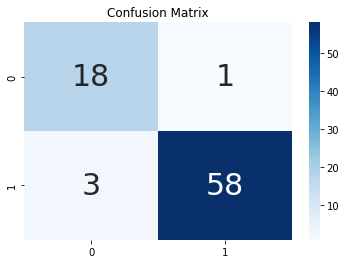

34/34 [==============================] - 2s 48ms/step
Accuracy:  0.9707271010387157
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       519
           1       0.97      0.97      0.97       540

    accuracy                           0.97      1059
   macro avg       0.97      0.97      0.97      1059
weighted avg       0.97      0.97      0.97      1059



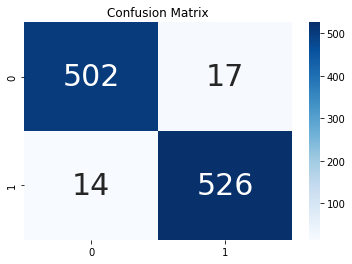

In [ ]:
#@title CNN com albumentation
#@markdown bc40fc1ae5c545cc982a2930b8b6c57c

import logging
import os
import shutil

import mlflow
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers, models

# from src.constants import (CHANNEL, IMG_HEIGHT, IMG_WIDTH,
#                            PREFIX_PROCESSED_DATA_PATH, TMP_DIR_PATH)
# from src.input_output_processing import (
#     describe_results, drop_valid_albumented_images_from_train_data,
#     get_df_train_test, get_df_train_valid,
#     get_df_train_with_albumentations_and_noises, get_processed_input_model)
# from src.visualization.visualize import (plot_confusion_matrix,
#                                          plot_train_history)

TAG = "CNN_2.0"


def train(
    input_shape,
    X_train_scaled_cnn,
    y_train,
    X_valid_scaled_cnn,
    y_valid,
    run_id,
    epochs=20,
):
    # model = models.Sequential()
    # model.add(layers.Conv2D(512, (3, 3), activation='relu', input_shape=input_shape))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))

    model = models.Sequential()
    model.add(layers.Conv2D(512, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            tf.keras.metrics.BinaryCrossentropy(),
            tf.keras.metrics.Accuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tfa.metrics.F1Score(num_classes=1, threshold=0.5),
        ],
    )

    if os.path.exists(TMP_DIR_PATH):
        shutil.rmtree(TMP_DIR_PATH)
    os.makedirs(TMP_DIR_PATH)

    prefix_filename = "{dir_path}/{tag}_{run_id}".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id
    )
    checkpoint_filepath = (
        prefix_filename + "_weights_{epoch:02d}_{val_loss}_{val_f1_score}.h5"
    )
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_f1_score",
        mode="max",
        save_best_only=True,
    )
    history = model.fit(
        X_train_scaled_cnn,
        y_train,
        steps_per_epoch=8,
        epochs=epochs,
        verbose=1,
        validation_data=(X_valid_scaled_cnn, y_valid),
        callbacks=[model_checkpoint_callback],
    )

    df_history = pd.DataFrame(history.history)
    df_history["f1_score"] = df_history["f1_score"].str[0].map(float)
    df_history["val_f1_score"] = df_history["val_f1_score"].str[0].map(float)
    df_history.to_csv("{}_history.csv".format(prefix_filename), index=False)

    plot_train_history(df_history, "{}_train".format(prefix_filename))
    return model


def predict(model, type_data, X_test_scaled_cnn, y_test, run_id):
    y_score = model.predict(X_test_scaled_cnn, verbose=1)
    df_y_true_pred_cnn = pd.DataFrame(
        {
            "y_true": y_test.to_numpy().flatten().tolist(),
            "y_pred": (pd.Series(y_score.flatten().tolist()) >= 0.5).astype("int64"),
            "y_score": y_score.flatten().tolist(),
        }
    )

    y_true = df_y_true_pred_cnn["y_true"]
    y_pred = df_y_true_pred_cnn["y_pred"]

    accuracy = accuracy_score(y_true, y_pred)
    precision_recall_fscore_support_metrics = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    df_precision_recall_fscore_support_cnn = pd.DataFrame(
        precision_recall_fscore_support_metrics,
        columns=[0, 1],
        index=["precision", "recall", "f1_score", "support"],
    ).T
    df_precision_recall_fscore_support_cnn["accuracy"] = accuracy
    df_precision_recall_fscore_support_cnn["model_name"] = "{}_{}".format(TAG, run_id)
    df_precision_recall_fscore_support_cnn = (
        df_precision_recall_fscore_support_cnn.reset_index().rename(
            columns={"index": "label"}
        )
    )

    prefix_filename = "{dir_path}/{tag}_{run_id}_{type_data}".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id, type_data=type_data
    )
    df_precision_recall_fscore_support_cnn.to_csv(
        "{}_metrics.csv".format(prefix_filename), index=False
    )

    describe_results(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, prefix_filename=prefix_filename)


def main():
    logging.info("Starting run {}".format(TAG))

    df_train, df_test = get_df_train_test(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, split=False
    )
    df_train, df_valid = get_df_train_valid(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, df=df_train, split=False
    )

    df_train_aux = get_df_train_with_albumentations_and_noises(df_train)
    df_train_aux, _ = drop_valid_albumented_images_from_train_data(
        df_train_aux, df_valid
    )

    (
        X_train_aux,
        y_train_aux,
        X_train_scaled_aux,
        X_train_scaled_cnn_aux,
    ) = get_processed_input_model(df_train_aux)
    X_valid, y_valid, X_valid_scaled, X_valid_scaled_cnn = get_processed_input_model(
        df_valid
    )
    X_test, y_test, X_test_scaled, X_test_scaled_cnn = get_processed_input_model(
        df_train_aux
    )

    input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNEL)

    with mlflow.start_run() as run:
        mlflow.set_tag("model.version", TAG)
        run = mlflow.active_run()
        run_id = run.info.run_id
        logging.info("Active run_id: {}".format(run_id))
        print("Active run_id: {}".format(run_id))
        mlflow.keras.autolog()

        model = train(
            input_shape,
            X_train_scaled_cnn_aux,
            y_train_aux,
            X_valid_scaled_cnn,
            y_valid,
            run_id,
            epochs=20,
        )
        predict(model, "valid", X_valid_scaled_cnn, y_valid, run_id)
        predict(model, "test", X_test_scaled_cnn, y_test, run_id)

        mlflow.log_artifacts(TMP_DIR_PATH)
    mlflow.end_run()

    logging.info("Ending run {}".format(TAG))


# if __name__ == "__main__":
main()


**Histórico da perda e do F1 score durante o treinamento da rede CNN**

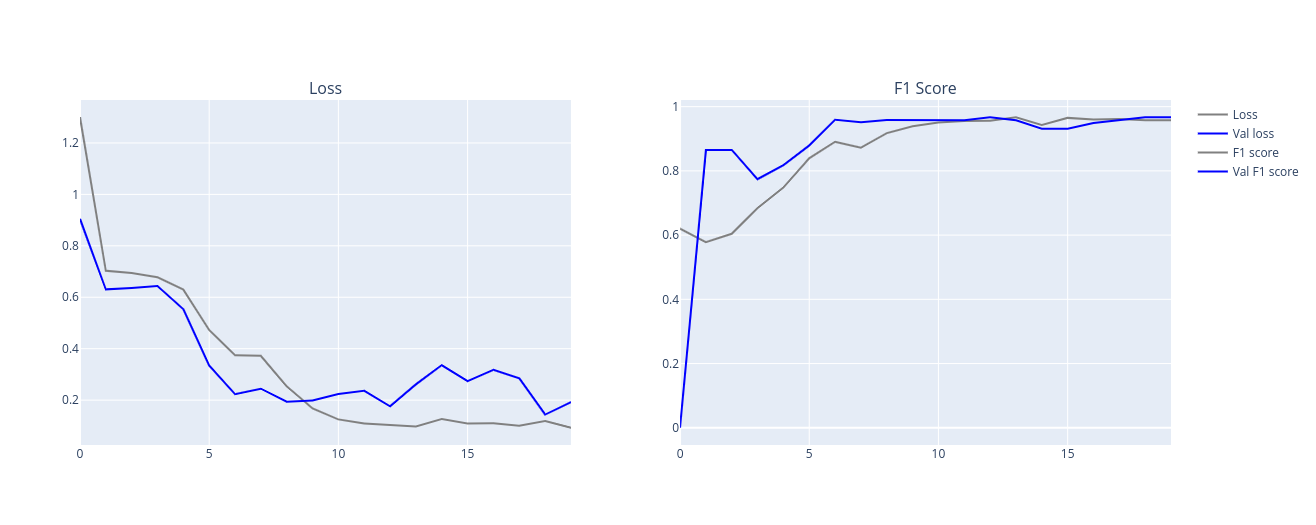

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 512)       38912     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 512)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 256)       3277056   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 22, 22, 256)      

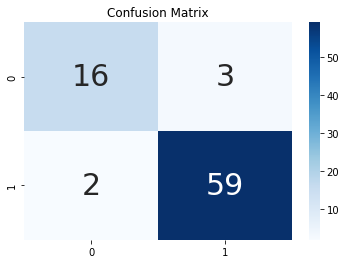

34/34 [==============================] - 2s 45ms/step
Accuracy:  0.9244570349386213
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       519
           1       0.91      0.94      0.93       540

    accuracy                           0.92      1059
   macro avg       0.93      0.92      0.92      1059
weighted avg       0.93      0.92      0.92      1059



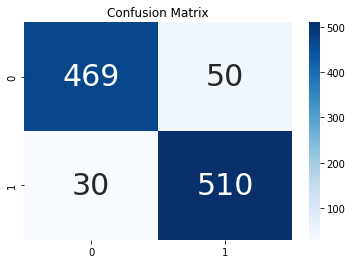

In [ ]:
#@title CNN com albumentation - check valid and test data with the best epoch weights (7)
#@markdown bc40fc1ae5c545cc982a2930b8b6c57c

import logging
import os
import shutil

import mlflow
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers, models

# from src.constants import (CHANNEL, IMG_HEIGHT, IMG_WIDTH,
#                            PREFIX_PROCESSED_DATA_PATH, TMP_DIR_PATH)
# from src.input_output_processing import (
#     describe_results, drop_valid_albumented_images_from_train_data,
#     get_df_train_test, get_df_train_valid,
#     get_df_train_with_albumentations_and_noises, get_processed_input_model)
# from src.visualization.visualize import (plot_confusion_matrix,
#                                          plot_train_history)

TAG = "CNN_2.0"

DEST_PATH = '/content/mlruns/0/bc40fc1ae5c545cc982a2930b8b6c57c/artifacts/'
CNN_BEST_WEIGHTS_FILEPATH = '/content/mlruns/0/bc40fc1ae5c545cc982a2930b8b6c57c/artifacts/CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c_weights_07_0.22325654327869415_[0.9593496].h5'
RUN_ID = 'bc40fc1ae5c545cc982a2930b8b6c57c'


def predict(model, type_data, X_test_scaled_cnn, y_test, run_id):
    y_score = model.predict(X_test_scaled_cnn, verbose=1)
    df_y_true_pred_cnn = pd.DataFrame(
        {
            "y_true": y_test.to_numpy().flatten().tolist(),
            "y_pred": (pd.Series(y_score.flatten().tolist()) >= 0.5).astype("int64"),
            "y_score": y_score.flatten().tolist(),
        }
    )

    y_true = df_y_true_pred_cnn["y_true"]
    y_pred = df_y_true_pred_cnn["y_pred"]

    accuracy = accuracy_score(y_true, y_pred)
    precision_recall_fscore_support_metrics = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1]
    )
    df_precision_recall_fscore_support_cnn = pd.DataFrame(
        precision_recall_fscore_support_metrics,
        columns=[0, 1],
        index=["precision", "recall", "f1_score", "support"],
    ).T
    df_precision_recall_fscore_support_cnn["accuracy"] = accuracy
    df_precision_recall_fscore_support_cnn["model_name"] = "{}_{}".format(TAG, run_id)
    df_precision_recall_fscore_support_cnn = (
        df_precision_recall_fscore_support_cnn.reset_index().rename(
            columns={"index": "label"}
        )
    )

    prefix_filename = "{dir_path}/{tag}_{run_id}_{type_data}".format(
        dir_path=TMP_DIR_PATH, tag=TAG, run_id=run_id, type_data=type_data
    )
    df_precision_recall_fscore_support_cnn.to_csv(
        "{}_metrics.csv".format(prefix_filename), index=False
    )

    describe_results(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, prefix_filename=prefix_filename)


def main():
    if os.path.exists(TMP_DIR_PATH):
        shutil.rmtree(TMP_DIR_PATH)
    os.makedirs(TMP_DIR_PATH)

    model = tf.keras.models.load_model(CNN_BEST_WEIGHTS_FILEPATH)
    model.summary()

    df_train, df_test = get_df_train_test(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, split=False
    )
    df_train, df_valid = get_df_train_valid(
        prefix_path=PREFIX_PROCESSED_DATA_PATH, df=df_train, split=False
    )

    df_train_aux = get_df_train_with_albumentations_and_noises(df_train)
    df_train_aux, _ = drop_valid_albumented_images_from_train_data(
        df_train_aux, df_valid
    )

    (
        X_train_aux,
        y_train_aux,
        X_train_scaled_aux,
        X_train_scaled_cnn_aux,
    ) = get_processed_input_model(df_train_aux)
    X_valid, y_valid, X_valid_scaled, X_valid_scaled_cnn = get_processed_input_model(
        df_valid
    )
    X_test, y_test, X_test_scaled, X_test_scaled_cnn = get_processed_input_model(
        df_train_aux
    )

    input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNEL)

    run_id = RUN_ID
    logging.info("Active run_id: {}".format(run_id))
    print("Active run_id: {}".format(run_id))
    
    predict(model, "valid_best", X_valid_scaled_cnn, y_valid, run_id)
    predict(model, "test_best", X_test_scaled_cnn, y_test, run_id)

    
    shutil.move(TMP_DIR_PATH, DEST_PATH)
    
    logging.info("Ending run {}".format(TAG))


# if __name__ == "__main__":
main()


# Models evaluation

In [ ]:
#@title get_df_metrics
def get_df_metrics(metrics_path):
  metrics = []
  for file_path in metrics_path:
    df = pd.read_csv(file_path)
    metrics.append(df)
    
  df_metrics = pd.concat(
    metrics, ignore_index=True
  )
  df_metrics['full_model_name'] = df_metrics['model_name']
  df_metrics['model_name'] = df_metrics['model_name'].str.split('_').str[0]

  return df_metrics

In [ ]:
#@title Conjunto de treinamento

valid_metrics = [
  '/content/mlruns/0/4e68bf17be194f6c97c602418326cba4/artifacts/LR_4e68bf17be194f6c97c602418326cba4_valid_metrics.csv',
  '/content/mlruns/0/2b8e7ef28381438d84df5226f588d763/artifacts/SVM_2b8e7ef28381438d84df5226f588d763_valid_metrics.csv',
  '/content/mlruns/0/bc40fc1ae5c545cc982a2930b8b6c57c/artifacts/CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c_valid_best_metrics.csv',
]

df_valid_metrics = get_df_metrics(valid_metrics)
display(df_valid_metrics)

compare_evaluation_metrics(df=df_valid_metrics, dataset='Validação')

,label,precision,recall,f1_score,support,accuracy,model_name,full_model_name
0,0,0.782609,0.947368,0.857143,19.0,0.9250,LR,LR_4e68bf17be194f6c97c602418326cba4
1,1,0.982456,0.918033,0.949153,61.0,0.9250,LR,LR_4e68bf17be194f6c97c602418326cba4
2,0,0.583333,0.736842,0.651163,19.0,0.8125,SVM,SVM_2b8e7ef28381438d84df5226f588d763
3,1,0.910714,0.836066,0.871795,61.0,0.8125,SVM,SVM_2b8e7ef28381438d84df5226f588d763
4,0,0.888889,0.842105,0.864865,19.0,0.9375,CNN,CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c
5,1,0.951613,0.967213,0.959350,61.0,0.9375,CNN,CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c


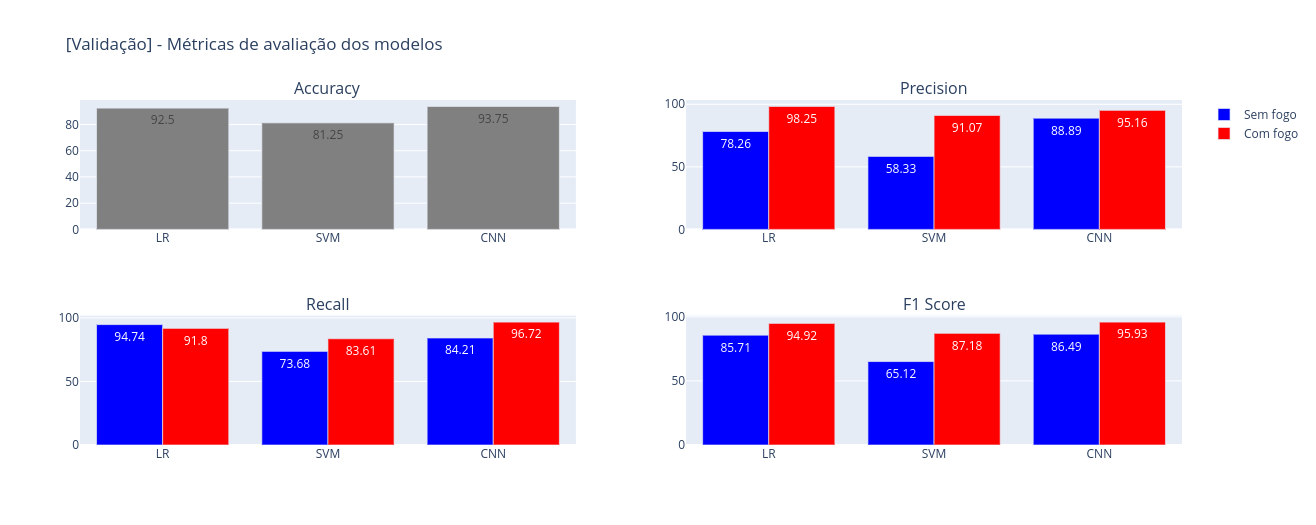

In [ ]:
#@title Conjunto de teste
test_metrics = [
  '/content/mlruns/0/4e68bf17be194f6c97c602418326cba4/artifacts/LR_4e68bf17be194f6c97c602418326cba4_test_metrics.csv',
  '/content/mlruns/0/2b8e7ef28381438d84df5226f588d763/artifacts/SVM_2b8e7ef28381438d84df5226f588d763_test_metrics.csv',
  '/content/mlruns/0/bc40fc1ae5c545cc982a2930b8b6c57c/artifacts/CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c_test_best_metrics.csv',
]

df_test_metrics = get_df_metrics(test_metrics)
display(df_test_metrics)

compare_evaluation_metrics(df=df_test_metrics, dataset='Teste')

,label,precision,recall,f1_score,support,accuracy,model_name,full_model_name
0,0,1.000000,1.000000,1.000000,519.0,1.000000,LR,LR_4e68bf17be194f6c97c602418326cba4
1,1,1.000000,1.000000,1.000000,540.0,1.000000,LR,LR_4e68bf17be194f6c97c602418326cba4
2,0,0.957565,1.000000,0.978322,519.0,0.978281,SVM,SVM_2b8e7ef28381438d84df5226f588d763
3,1,1.000000,0.957407,0.978240,540.0,0.978281,SVM,SVM_2b8e7ef28381438d84df5226f588d763
4,0,0.939880,0.903661,0.921415,519.0,0.924457,CNN,CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c
5,1,0.910714,0.944444,0.927273,540.0,0.924457,CNN,CNN_2.0_bc40fc1ae5c545cc982a2930b8b6c57c


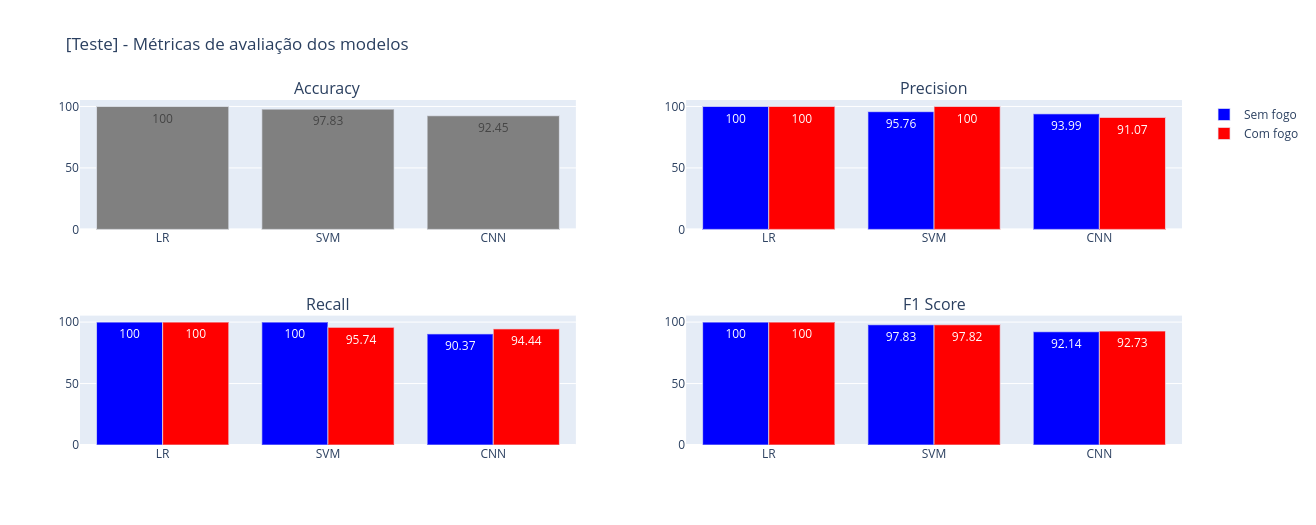